In [1]:
import taichi as ti
import numpy as np
import math
from sympy import inverse_mellin_transform
from pyevtk.hl import gridToVTK
import pandas as pd
import matplotlib.pyplot as plt
import os
import argparse
import random

ti.init(arch=ti.cpu, flatten_if=True)

dim = 2
Q = 9 
real = ti.f32
i32_vec2d = ti.types.vector(2, ti.i32)
f32_vec2d = ti.types.vector(2, ti.f32)
scalar_real = lambda: ti.field(dtype=real)
scalar_int = lambda: ti.field(dtype=ti.i32)
vec = lambda: ti.Vector.field(dim, dtype=real)
vec_Q = lambda: ti.Vector.field(Q, dtype=real)

# Input paramters
ly = 160
lx = 400
v_left = 0.2
dx = 40/lx
dt = v_left*dx

print(dx,dt)

x = np.linspace(0, lx)
y = np.linspace(0, ly)
X, Y = np.meshgrid(x, y, indexing="ij")
rhos = 3.

s_v = scalar_real() 

loss = scalar_real()
rhof = scalar_real()

is_solid = scalar_int()

v = vec()

temp_v = vec()
target_v =  vec() # target velocity field

rho = scalar_real()
target_rho = scalar_real()

collide_f = vec_Q()
stream_f = vec_Q()

ti.root.dense(ti.ij, (lx, ly)).place(is_solid)
ti.root.dense(ti.ij, (lx, ly)).place(target_v,target_rho)
ti.root.dense(ti.ij, (lx, ly)).place(rho,v,temp_v)
ti.root.dense(ti.ij, (lx, ly)).place(collide_f,stream_f)
ti.root.place(loss,s_v,rhof)

ti.root.lazy_grad()

"""Definition of LBM parameters"""
half = (Q - 1) // 2
# LBM weights
w0 = 4.0 / 9.0
w1 = 1.0 / 36.0
w2 = 1.0 / 9.0
w_np = np.array([w0, w1, w2, w1, w2, w1, w2, w1, w2])

# x component of predefined velocity in Q directions
e_xy_list = [
    [0, 0],
    [-1, 1],
    [-1, 0],
    [-1, -1],
    [0,-1],
    [1, -1],
    [1, 0],
    [1, 1],
    [0, 1],
]

# reversed_e_xy_np stores the index of the opposite component to every component in e_xy_np
# For example, for [1,0,0], the opposite component is [-1,0,0] which has the index of 2 in e_xy
reversed_e_index = np.array([e_xy_list.index([-a for a in e]) for e in e_xy_list])

"""MRT"""
M_np = np.array(
    [
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0,1,0,-1,0,1,-1,-1,1],
    [0,0,1,0,-1,1,1,-1,-1],
    [0,1,1,1,1,2,2,2,2],
    [0,1,-1,1,-1,0,0,0,0],
    [0,0,0,0,0,1,-1,1,-1],
    [0,0,0,0,0,1,1,-1,-1],
    [0,0,0,0,0,1,-1,-1,1],
    [0, 0, 0, 0, 0, 1,1,1,1],
    ]
)
inv_M_np = np.linalg.inv(M_np)

M_mat = ti.Matrix.field(Q, Q, ti.f32, shape=())
inv_M_mat = ti.Matrix.field(Q, Q, ti.f32, shape=())
M_mat[None] = ti.Matrix(M_np)
inv_M_mat[None] = ti.Matrix(inv_M_np)
  
# Diagonal relaxation matrix for fluid 1
S_dig_vec = ti.Vector.field(Q, ti.f32, shape=())
S_dig_vec[None] = ti.Vector(
    [
        1,
        1.5,
        1.4,
        1,
        1.5,
        1,
        1.5,
        1.,
        1.,
    ]
)

w = ti.field(ti.f32,shape=Q)
w.from_numpy(w_np)
e_xy = ti.Vector.field(n=2, dtype=ti.i32, shape=Q)
e_xy.from_numpy(np.array(e_xy_list))

ti.static(e_xy)
ti.static(w)
ti.static(M_mat)
ti.static(inv_M_mat)
ti.static(S_dig_vec)

# Writing input model (here we make a grain sample
def place_sphere(x, y, R):
    global solid_count
    
    xmin = x - R
    ymin = y - R
    xmax = x + R
    ymax = y + R

    for px in range(xmin, xmax + 1):
        for py in range(ymin, ymax + 1):
            dx = px - x
            dy = py - y
        
            dist2 = dx * dx + dy * dy 
            R2 = R * R
            if dist2 < R2:
                near_px = (
                    math.floor(px + 0.5)
                    if math.floor(px + 0.5)
                    else math.floor(px + 0.5) + lx
                )
                near_py = (
                    math.floor(py + 0.5)
                    if math.floor(py + 0.5)
                    else math.floor(py + 0.5) + ly
                )
                
                if near_px >= lx:
                    near_px -= lx
                if near_py >= ly:
                    near_py -= ly
                
                if is_solid[near_px, near_py]==0:
                    is_solid[near_px, near_py] = 1
                    solid_count +=1

solid_count = 0
place_sphere(150,80,5)

ti.static(is_solid)


[Taichi] version 1.1.3, llvm 10.0.0, commit 1262a70a, linux, python 3.10.10
[I 03/21/23 18:00:35.607 55221] [shell.py:_shell_pop_print@33] Graphical python shell detected, using wrapped sys.stdout


Error: Can not import avx core while this file exists: /home/amber/.local/lib/python3.10/site-packages/paddle/fluid/core_avx.so


[Taichi] Starting on arch=x64
0.1 0.020000000000000004
    x = ti.field(ti.f32, (9, 9)).
 See https://docs.taichi-lang.org/docs/field#matrix-size for more details.
  File "/usr/lib64/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib64/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/amber/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/amber/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/home/amber/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "/home/amber/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib64/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._ru

[W 03/21/23 18:00:39.001 55221] [type_check.cpp:type_check_store@36] [$524] Global store may lose precision: f32 <- f64
File "/home/amber/.local/lib/python3.10/site-packages/taichi/_kernels.py", line 125, in ext_arr_to_tensor:
        tensor[I] = arr[I]
        ^^^^^^^^^^^^^^^^^^



<ti.field>

In [2]:
@ti.func
def periodic_index(i):
    iout = i
    if i[0]<0:     iout[0] = lx-1
    if i[0]>lx-1:  iout[0] = 0
    if i[1]<0:     iout[1] = ly-1
    if i[1]>ly-1:  iout[1] = 0

    return iout

@ti.func
def velocity_vec(local_pos) -> f32_vec2d:
    velocity_vec = ti.Vector([0., 0.])    
    for i in ti.static(range(2)):
        for s in ti.static(range(Q)):
            velocity_vec[i] = velocity_vec[i] + (collide_f[local_pos][s]* e_xy[s][i])
        velocity_vec[i] = velocity_vec[i]/rho[local_pos] 

    return velocity_vec

@ti.func
def feq(k,rho_local, u): # anti bounce-back pressue bound
    eu = e_xy[k].dot(u)
    uv = u.dot(u)
    feqout = w[k]*rho_local*(1.0+3.0*eu+4.5*eu*eu-1.5*uv)
    return feqout

@ti.kernel
def init_field():  
    for x, y in ti.ndrange(lx, ly):
        rho[x,y] = rhof[None]
        v[x,y] = ti.Vector([0., 0.])
        collide_f[x,y] = ti.Vector([0.,0.,0.,0.,0.,0.,0.,0.,0.])
        stream_f[x,y] = ti.Vector([0., 0.,0., 0.,0., 0.,0., 0.,0.])

        if is_solid[x,y] <= 0:
            for q in ti.static(range(Q)):
                collide_f[x,y][q] = w[q] * rho[x,y]
                stream_f[x,y][q] = w[q] * rho[x,y]      

@ti.kernel
def collision():
    for I in ti.grouped(collide_f):
        if (I.x < lx and I.y<ly and is_solid[I] <= 0):     
            """MRT operator"""
            a = 1./36.
            v[I] = velocity_vec(I)
                
            e = -4 * collide_f[I][0] + 2 * collide_f[I][1] - collide_f[I][2] + 2 * collide_f[I][3] -collide_f[I][4] + 2 * collide_f[I][5] - collide_f[I][6] + 2 * collide_f[I][7] - collide_f[I][8] 
            eps = 4 * collide_f[I][0] + collide_f[I][1] - 2 * collide_f[I][2] + collide_f[I][3] -2 * collide_f[I][4] + collide_f[I][5] - 2 * collide_f[I][6] + collide_f[I][7] - 2 * collide_f[I][8]

            j_x = collide_f[I][5] + collide_f[I][6] + collide_f[I][7] - collide_f[I][1] - collide_f[I][2] - collide_f[I][3]
            q_x = -collide_f[I][1] + 2 * collide_f[I][2] - collide_f[I][3] + collide_f[I][5] - 2 * collide_f[I][6] + collide_f[I][7]
            j_y = collide_f[I][1] + collide_f[I][8] + collide_f[I][7] - collide_f[I][3] - collide_f[I][4] - collide_f[I][5]
            q_y = collide_f[I][1] - collide_f[I][3] + 2 * collide_f[I][4] - collide_f[I][5] + collide_f[I][7] - 2 * collide_f[I][8]
            p_xx = collide_f[I][2] - collide_f[I][4] + collide_f[I][6] - collide_f[I][8]
            p_xy = -collide_f[I][1] + collide_f[I][3] - collide_f[I][5] + collide_f[I][7]

            j_x2 = j_x * j_x
            j_y2 = j_y * j_y

            eO = e -S_dig_vec[None][1] * (e + 2 * rho[I] - 3 * (j_x2 + j_y2) / rho[I])
            epsO = eps - S_dig_vec[None][2] * (eps - rho[I] + 3 * (j_x2 + j_y2) / rho[I])
            q_xO = q_x - S_dig_vec[None][3] * (q_x + j_x)
            q_yO = q_y - S_dig_vec[None][6] * (q_y + j_y)
            p_xxO = p_xx - s_v[None] * (p_xx - (j_x2 - j_y2) / rho[I])
            p_xyO = p_xy - s_v[None] * (p_xy - j_x * j_y / rho[I])
            
            collide_f[I][0] = a * (4*rho[I] - 4 * eO + 4 * epsO)
            collide_f[I][2] = a * (4*rho[I] - eO - 2*epsO - 6*j_x + 6*q_xO + 9*p_xxO)
            collide_f[I][4] = a * (4*rho[I] - eO - 2*epsO - 6*j_y + 6*q_yO - 9*p_xxO)
            collide_f[I][6] = a * (4*rho[I] - eO - 2*epsO + 6*j_x - 6*q_xO + 9*p_xxO)
            collide_f[I][8] = a * (4*rho[I] - eO - 2*epsO + 6*j_y - 6*q_yO - 9*p_xxO)
            collide_f[I][1] = a * (4*rho[I] + 2*eO + epsO - 6*j_x - 3*q_xO + 6*j_y + 3*q_yO - 9*p_xyO)
            collide_f[I][3] = a * (4*rho[I] + 2*eO + epsO - 6*j_x - 3*q_xO - 6*j_y - 3*q_yO + 9*p_xyO)
            collide_f[I][5] = a * (4*rho[I] + 2*eO + epsO + 6*j_x + 3*q_xO - 6*j_y - 3*q_yO - 9*p_xyO)
            collide_f[I][7] = a * (4*rho[I] + 2*eO + epsO + 6*j_x + 3*q_xO + 6*j_y + 3*q_yO + 9*p_xyO)


@ti.kernel
def boundary_condition():  
    for I in ti.grouped(v):
        if (I.x < lx and I.y<ly and is_solid[I]<=0):
            for s in ti.static(range(Q)):
                if I.x==0:
                    stream_f[I][s]= feq(s, rho[I], ti.Vector([v_left,0.]))

    for I in ti.grouped(v):
        if (I.x < lx and I.y<ly and is_solid[I] <= 0): 
            collide_f[I] = stream_f[I] 
            rho[I] = collide_f[I].sum()

@ti.kernel
def streaming():
    for I in ti.grouped(collide_f):
        if (I.x < lx and I.y<ly and is_solid[I] <= 0):
            for s in ti.static(range(Q)):
                neighbor_pos = periodic_index(I+e_xy[s])
                if (is_solid[neighbor_pos]<=0):
                    stream_f[neighbor_pos][s] = collide_f[I][s]
                else:
                    stream_f[I][reversed_e_index[s]] = collide_f[I][s]  

def export_VTK(n):
    is_solid_3d = np.ascontiguousarray(is_solid.to_numpy()[0:lx,0:ly]).reshape(lx,ly,1)
    rho_3d = np.ascontiguousarray(rho.to_numpy()[0:lx,0:ly]).reshape(lx,ly,1)
    v_ = v.to_numpy()[0:lx,0:ly,:]/dt
    v_3d = v_[0:lx,0:ly,np.newaxis,:]

    grid_x = np.linspace(0, lx, lx)
    grid_y = np.linspace(0, ly, ly)
    z = np.array([0.0])

    gridToVTK(
            "./LB_SingelPhase_"+str(n),
            grid_x,
            grid_y,
            z,
            pointData={ "Solid": is_solid_3d,
                        "rho": rho_3d,
                        "velocity": (np.ascontiguousarray(v_3d[:,:,:,0]),
                                     np.ascontiguousarray(v_3d[:,:,:,1]),
                                     np.ascontiguousarray((v_3d[:,:,:,0]**2+v_3d[:,:,:,1]**2)**0.5),
                                        )
                        }
        )  

@ti.kernel
def update_vel():
    for I in ti.grouped(v): 
        v[I] = velocity_vec(I)
        
def run(max_step=1000,compute_loss=True):
    step = 0   
#     Update_Sdig()
    init_field()
    while step < max_step:  
        collision() 
        streaming()
        boundary_condition()
        
        if step%50 == 0:
            export_VTK(step//50)
        step +=1 
    
    if compute_loss:
        update_vel()
        for i in range(lx):
            for j in range(ly):
                target_v[i,j] = v[i,j]
                target_rho[i,j] = rho[i,j]

@ti.kernel
def compute_loss():  
    for I in ti.grouped(v): 
#         if (I.x < lx and I.y<ly and is_solid[I]<=0 and I.y >=60 and I.y<=100 and I.x>=160 and I.x<=230):
        if (I.x < lx and I.y<ly and is_solid[I]<=0):
            for i in ti.static(range(2)):
                temp_v[I][i]=0.
                for s in ti.static(range(Q)):
                    temp_v[I][i] = temp_v[I][i] + (collide_f[I][s]* e_xy[s][i])
                temp_v[I][i] = temp_v[I][i]/rho[I] 
                
            loss[None]+= (target_v[I].norm()-temp_v[I].norm())**2

In [3]:
##set target velocity field 
loss[None] = 0.
viscosity = 0.01
viscosity_lbm = viscosity*dt/(dx**2)

s_v[None]=1/(3*viscosity_lbm+5)
print(viscosity_lbm,s_v[None])

rhof[None] = 1
run(max_step=6000,compute_loss=True)
compute_loss()
print(loss[None])

0.02 0.197628453373909
0.0


In [4]:
"""Success"""
# initial value of dp
init_viscosity = 0.1
s_v[None] = 1/(3*init_viscosity+5)
print("initial guess of viscosity = ",init_viscosity)
print("initial guess of S_v = ",s_v[None])

rhof[None]= 1.
learning_rate_s_v = 0.001
learning_rate_rho =  0.01
loss.grad[None] = 1.

init_loss = 0

# Arrays of deriavtives 
v_array = []
rhof_array = []
loss_array = []

for iteration in range(100):
    init_field()
    for step in range(6000):
        with ti.ad.Tape(loss=loss): 
            collision() 
            streaming()
            boundary_condition()
            compute_loss()
            
    loss_array.append(loss[None])
    viscosity = (1/s_v[None]-5)/3
    
    v_array.append(viscosity)
    print("dloss/ds_v = {}, viscosity = {}, \nS_v = {},loss = {} at No. {}.".format(s_v.grad[None],
                                                                               viscosity,s_v[None],
                                                                                    loss[None],
                                                                                    iteration))
    if iteration ==0:
        init_loss = loss[None]
#     s_v[None] -= loss[None]/s_v.grad[None] * learning_rate_s_v
    s_v[None] -= s_v.grad[None] * learning_rate_s_v


initial guess of viscosity =  0.1
initial guess of S_v =  0.18867924809455872
dloss/ds_v = -7.827079772949219, viscosity = 0.0999999736746157, 
S_v = 0.18867924809455872,loss = 0.019891245290637016 at No. 0.
dloss/ds_v = -0.9282029271125793, viscosity = 0.029631604591361455, 
S_v = 0.1965063214302063,loss = 0.00029888609424233437 at No. 1.
dloss/ds_v = -0.15949630737304688, viscosity = 0.021656717818120914, 
S_v = 0.19743452966213226,loss = 8.880600034899544e-06 at No. 2.
dloss/ds_v = -0.028274236246943474, viscosity = 0.0202938679190859, 
S_v = 0.1975940316915512,loss = 2.8051863409928046e-07 at No. 3.
dloss/ds_v = -0.005099132191389799, viscosity = 0.02005256842098498, 
S_v = 0.19762229919433594,loss = 9.10712927293389e-09 at No. 4.
dloss/ds_v = -0.0009436407126486301, viscosity = 0.02000907316717626, 
S_v = 0.19762739539146423,loss = 4.5608444798617143e-10 at No. 5.
dloss/ds_v = -0.00019954027084168047, viscosity = 0.020001061128250914, 
S_v = 0.19762833416461945,loss = 1.7354541415

KeyboardInterrupt: 

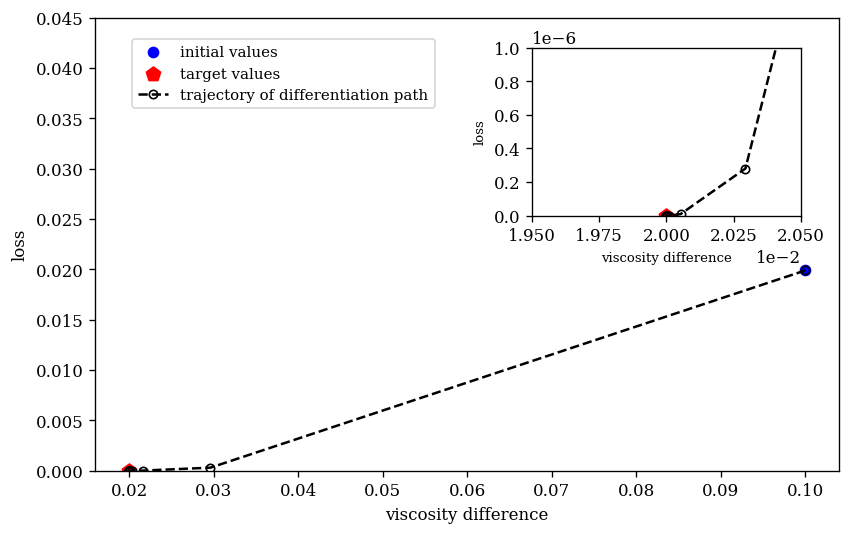

In [15]:
plt.rcParams['font.family'] = 'DeJavu Serif' 
plt.rcParams["font.serif"] = "Times New Roman"


fig,ax1 = plt.subplots(figsize=(8,5),dpi=120)
# ax1.set_xlim(0.99, 1.61)
# ax1.set_ylim(400, 1200)


ax1.scatter(init_viscosity,init_loss,color='blue',label = 'initial values')

ax1.scatter(0.02,0,color='red',label = 'target values',marker='p', s=80)

ax1.plot(v_array, loss_array, linestyle='--',marker='o', markersize=5, 
markerfacecolor='none',color='black',label = 'trajectory of differentiation path')
# ax1.set_xlim([0.0,0.09])
ax1.set_ylim([0, 0.045])

plt.xlabel(r'viscosity difference', fontsize=10)
# plt.xlabel(r'pressure difference ($\rm Pa$)', fontsize=10)
plt.ylabel('loss', fontsize=10)

left, bottom, width, height = [0.58, 0.55, 0.28, 0.28]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.scatter(0.02,0,color='red',label = 'target values',marker='p', s=80)

ax2.plot(v_array, loss_array, linestyle='--',marker='o', markersize=5, 
markerfacecolor='none',color='black',label = 'trajectory of differentiation path')
ax2.set_xlim([0.0195, 0.0205])
ax2.set_ylim([0.0, 1e-6])
plt.ticklabel_format(axis='both', style='sci',scilimits=(0,0))

ax1.legend(fontsize=9,loc=(0.05,0.8))
plt.xlabel(r'viscosity difference', fontsize=8)
# plt.xlabel(r'pressure difference ($\rm Pa$)', fontsize=9)
plt.ylabel('loss', fontsize=8)
plt.show() 